We write a neural network for the iris dataset from scratch, copying generously from Karpathy's [micrograd](https://github.com/karpathy/micrograd). We implement SGD for the training loop. Originally I wanted to replicate the MNIST network in Michael Nielson's [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html#implementing_our_network_to_classify_digits), but training it took too long.


In [55]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math
import random
from graphviz import Digraph
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris  # noqa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def sigmoid(self):
        return Value(1) / (1 + (-self).exp())

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.sigmoid()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [13]:
class SGD:
    def __init__(self, nn, training_data, epochs, mini_batch_size, alpha):
        self.nn = nn
        self.training_data = training_data
        self.epochs = epochs
        self.mini_batch_size = mini_batch_size
        self.alpha = alpha

    def train(self):
        for epoch in range(self.epochs):
            random.shuffle(self.training_data)
            mini_batches = [
                self.training_data[k : k + self.mini_batch_size]
                for k in range(0, len(self.training_data), self.mini_batch_size)
            ]
            epoch_loss = 0
            for mini_batch in mini_batches:
                loss = self.update_mini_batch(mini_batch)
                epoch_loss += loss
            print(f"Epoch {epoch} complete with loss {epoch_loss}")

    def update_mini_batch(self, mini_batch):
        # Forward pass
        cost_sum = Value(0)
        for x, y in mini_batch:
            pred = self.nn(x)
            if not isinstance(pred, list):
                pred = [pred]
            if not isinstance(y, list):
                y = [y]
            squared_error = sum((pred - label) ** 2 for pred, label in zip(pred, y))
            cost_sum += squared_error
        final_cost = cost_sum * (1.0 / (2 * self.mini_batch_size))

        # Backward pass
        parameters = self.nn.parameters()
        for p in parameters:
            p.grad = 0.0
        final_cost.backward()

        # Update weights and biases (parameters) of the model
        for p in parameters:
            p.data = p.data - self.alpha * p.grad

        return final_cost.data

In [27]:
x, y = load_iris(return_X_y=True)
# One-hot encode the ys
x = x.tolist()
y = np.eye(3)[y].tolist()
dataset = list(zip(x, y))

In [28]:
mlp = MLP(4, [3, 3])
trainer = SGD(mlp, dataset, 150, 10, 0.5)
trainer.train()

Epoch 0 complete with loss 5.228109863636578
Epoch 1 complete with loss 4.811590527515836
Epoch 2 complete with loss 4.571267491177194
Epoch 3 complete with loss 4.3829861375233214
Epoch 4 complete with loss 4.197913007139084
Epoch 5 complete with loss 4.038164541182581
Epoch 6 complete with loss 3.872290225148203
Epoch 7 complete with loss 3.7068483386813447
Epoch 8 complete with loss 3.5886929561863177
Epoch 9 complete with loss 3.477471591816729
Epoch 10 complete with loss 3.3726498536848086
Epoch 11 complete with loss 3.3036160667866366
Epoch 12 complete with loss 3.243014975791261
Epoch 13 complete with loss 3.1598249158928664
Epoch 14 complete with loss 3.108013472082669
Epoch 15 complete with loss 3.0575501646923327
Epoch 16 complete with loss 3.0128253161335805
Epoch 17 complete with loss 2.9899654206296997
Epoch 18 complete with loss 2.955836597378141
Epoch 19 complete with loss 2.9267921080388213
Epoch 20 complete with loss 2.9016587867839307
Epoch 21 complete with loss 2.868

In [30]:
# Evaluate model accuracy on dataset
correct = 0
for x, y in dataset:
    pred = mlp(x)
    pred = [p.data for p in pred]
    if np.argmax(pred) == np.argmax(y):
        correct += 1
print(f"Accuracy: {correct / len(dataset)}")

Accuracy: 0.9533333333333334


Playing around with Michael Nielson's implementation.


In [45]:
import mnist_loader

In [46]:
"""
network.py
~~~~~~~~~~

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""


class Network(object):
    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data:
            n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k : k + mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print(f"Epoch {j}: {self.evaluate(test_data)} / {n_test}")
            else:
                print(f"Epoch {j} complete")

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [
            w - (eta / len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x]  # list to store all the activations, layer by layer
        zs = []  # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y


#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

In [50]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
# Convert zip iterators to lists
training_data = list(training_data)
validation_data = list(validation_data)
test_data = list(test_data)

In [48]:
net = Network([784, 30, 10])

In [51]:
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

Epoch 0: 9050 / 10000
Epoch 1: 9187 / 10000
Epoch 2: 9289 / 10000
Epoch 3: 9295 / 10000
Epoch 4: 9311 / 10000
Epoch 5: 9328 / 10000
Epoch 6: 9369 / 10000
Epoch 7: 9329 / 10000
Epoch 8: 9415 / 10000
Epoch 9: 9393 / 10000
Epoch 10: 9377 / 10000
Epoch 11: 9438 / 10000
Epoch 12: 9435 / 10000
Epoch 13: 9388 / 10000
Epoch 14: 9445 / 10000
Epoch 15: 9437 / 10000
Epoch 16: 9437 / 10000
Epoch 17: 9430 / 10000
Epoch 18: 9452 / 10000
Epoch 19: 9447 / 10000
Epoch 20: 9407 / 10000
Epoch 21: 9468 / 10000
Epoch 22: 9455 / 10000
Epoch 23: 9450 / 10000
Epoch 24: 9459 / 10000
Epoch 25: 9430 / 10000
Epoch 26: 9449 / 10000
Epoch 27: 9476 / 10000
Epoch 28: 9450 / 10000
Epoch 29: 9467 / 10000


Replicating some results from the chapter 3:


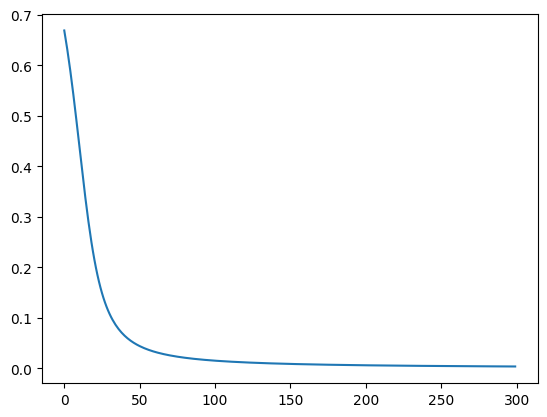

In [60]:
neuron = Neuron(1)
neuron.w = [Value(0.6)]
neuron.b = Value(0.9)

# We are inputting 1 and want an output of 0

losses = []
for i in range(300):
    pred = neuron([1.0])
    loss = (pred - Value(0)) ** 2
    losses.append(loss.data)
    for p in neuron.parameters():
        p.grad = 0
    loss.backward()
    for p in neuron.parameters():
        p.data = p.data - 0.15 * p.grad

plt.plot(losses)

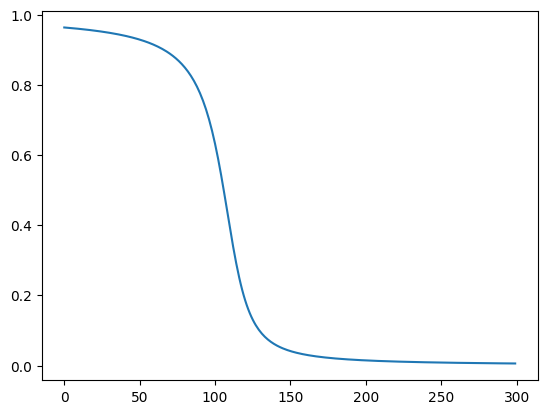

In [61]:
neuron = Neuron(1)
neuron.w = [Value(2.0)]
neuron.b = Value(2.0)

# We are inputting 1 and want an output of 0

losses = []
for i in range(300):
    pred = neuron([1.0])
    loss = (pred - Value(0)) ** 2
    losses.append(loss.data)
    for p in neuron.parameters():
        p.grad = 0
    loss.backward()
    for p in neuron.parameters():
        p.data = p.data - 0.15 * p.grad

plt.plot(losses)